Small Message Latency Loopback vs X-socket vs X-node (TODO add a 2 hop latency)

In [1]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nvhostpath = "../results/summit/host/standard/nvshmem/02-20-20.14.04.48/nvtests/host"
nvdevpath = "../results/summit/device/standard/nvshmem/02-20-20.14.04.48/nvtests/device"
ibpath = "../results/summit/device/standard/ib/02-03-20.12.58.07/device"

f_ib_xnode = "ib_read_lat.xnode"
f_nv = "latency.out"
f_nv_dev = "shmem_get_latency.out"

In [3]:
#output format is min, max, typical, avg, stddev, 99th, 99.9 
#unit is usec
def read_ib_lat(msg_size, file):
    data = {}
    with open(file, 'r') as f:
        for line in f.readlines():
            #print(line)
            tmp = line.lstrip().split()
            if tmp == []:
                continue
            elif tmp[0] == str(msg_size):
                data["tmin"] = tmp[2]
                data["tmax"] = tmp[3]
                data["tmed"] = tmp[4]
                data["tavg"] = tmp[5]
                data["tstd"] = tmp[6]
                return data
        return None
    
def read_nvshmem_lat(msg_size, file):
    data = {}
    with open(file, 'r') as f:
        for line in f.readlines():
            #print(line)
            tmp = line.lstrip().split()
            if tmp == []:
                continue
            elif tmp[0] == str(msg_size):
                data["tavg"] = tmp[1]
                return data
        return None

In [31]:
means = []
f = f_ib_xnode
tmp = read_ib_lat(8, join(ibpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv
tmp = read_nvshmem_lat(8, join(nvhostpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv_dev
tmp = read_nvshmem_lat(8, join(nvdevpath, f))
print(tmp)
means += [float(tmp["tavg"])]

{'tmin': '1.76', 'tmax': '1.84', 'tmed': '1.78', 'tavg': '1.78', 'tstd': '0.01'}
{'tavg': '2.40'}
{'tavg': '11.13'}


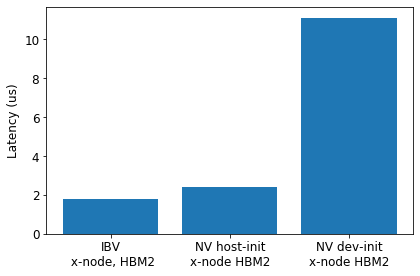

In [36]:
#This figure shows the difference that the wire and switch latency add for a single hop.
fig, ax = plt.subplots()
labels=["IBV host-init\n x-node, HBM2", "NV host-init\nx-node HBM2", "NV dev-init\nx-node HBM2"]
x = np.arange(len(labels))
ax.bar(range(len(means)), means, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_title("Latency for VERBS and NVSHMEM 8B get ops.\n Host initiated, HBM2")
ax.set_ylabel("Latency (us)")
matplotlib.rcParams.update({'font.size': 12})
fig.tight_layout()
plt.show()
fig.savefig("8B-ibvsnv-hbm-latency.png")

In [38]:
means[2]-means[0]

9.350000000000001

In [29]:
means = []
f = f_nv
tmp = read_nvshmem_lat(8, join(nvhostpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv_dev
tmp = read_nvshmem_lat(8, join(nvdevpath, f))
print(tmp)
means += [float(tmp["tavg"])]

{'tavg': '2.40'}
{'tavg': '11.13'}


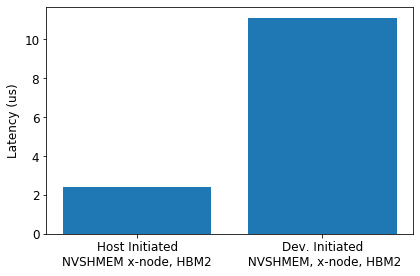

In [30]:
#This figure shows the difference that the wire and switch latency add for a single hop.
fig, ax = plt.subplots()
labels=["Host Initiated\nNVSHMEM x-node, HBM2", "Dev. Initiated\n NVSHMEM, x-node, HBM2"]
x = np.arange(len(labels))
ax.bar(range(len(means)), means, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_title("Latency for NVSHMEM 8B get ops.\n Host vs Device Control")
ax.set_ylabel("Latency (us)")
matplotlib.rcParams.update({'font.size': 12})
fig.tight_layout()
plt.show()
fig.savefig("8B-nv-hostvsdev-latency.png")

In [27]:
means

[1.78, 2.4]

In [28]:
meanshost = []
meansdev = []

for m in [2**x for x in range(3, 16)]:
    tmp = read_nvshmem_lat(m, join(nvhostpath, f_nv))
    print(tmp)
    meanshost += [float(tmp["tavg"])]
    f = f_nv_dev
    tmp = read_nvshmem_lat(m, join(nvdevpath, f_nv_dev))
    print(tmp)
    meansdev += [float(tmp["tavg"])]

{'tavg': '2.40'}
{'tavg': '11.13'}
{'tavg': '2.00'}
{'tavg': '10.58'}
{'tavg': '2.00'}
{'tavg': '10.68'}
{'tavg': '1.90'}
{'tavg': '10.71'}
{'tavg': '2.00'}
{'tavg': '10.84'}
{'tavg': '2.10'}
{'tavg': '10.56'}
{'tavg': '2.10'}
{'tavg': '10.61'}
{'tavg': '2.20'}
{'tavg': '10.67'}
{'tavg': '2.40'}
{'tavg': '11.17'}
{'tavg': '2.70'}
{'tavg': '11.39'}
{'tavg': '4.00'}
{'tavg': '12.25'}
{'tavg': '5.20'}
{'tavg': '13.43'}
{'tavg': '7.20'}
{'tavg': '15.66'}


In [30]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

xs=[2**x for x in range(3, 16)]
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in xs], [[y] for y in meanshost])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in xs], [[y] for y in meansdev])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

Coefficients: 
 [[0.00016496]]
[2.10697862]
Coefficients: 
 [[0.00015465]]
[10.73433033]


In [34]:
for v in meanshost:
    print(v)

2.4
2.0
2.0
1.9
2.0
2.1
2.1
2.2
2.4
2.7
4.0
5.2
7.2
